<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

##### 8th exercise: <font color="#C70039">Work with a regular Generative Adversarial Network (GAN)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   01.07.2022

<img src="https://www.researchgate.net/publication/338509383/figure/fig1/AS:845792709464064@1578664104008/Overview-of-generative-adversarial-network-GAN.ppm" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
The code implements a regular GAN that generates images using a random latent vector as input. While it works great we do not know the mapping of latent vector to the generated image.

Conditional GANs, however, can be used to supply a label during taining so the latent vector can be associated with a specific label - making the generation of images predictable. 

The below coded GAN is using the so-called cifar10 data set, which is standard to many machine learning application.
Following code trains and generates images based on that cifar10 data set, that is included in the Keras package. 
Further information can be found here: <a href="https://en.wikipedia.org/wiki/CIFAR-10"> cifar10 data set (wiki)</a>

The code is adapted from the code by Jason Brownlee from his blogs on <a href="https://machinelearningmastery.com/">https://machinelearningmastery.com/</a>
I seriously urge everyone to follow his blogs and get enlightened. Hence, original credit goes to Jason. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. ... .
---------------------------------

### GAN


In [4]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout

from tensorflow.keras.datasets.cifar10 import load_data
# this one is needed because there is a problem with the Secure Socket Layer (SSL) certificate, 
# you can resolve this with the help of the below line of code
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


### Build the GAN architeture

Use the "functional" way of defining the model for the conditional gan but use "sequential" for descriminator and generator as they are straight forward.

#### Define the standalone discriminator model

Given an input image, the Discriminator outputs the likelihood of the image being real.
Binary classification - true or false (1 or 0). So use the sigmoid activation.

In [8]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential(name="discriminator")

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape)) #16x16x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same')) #8x8x128
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten()) #shape of 8192
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) #shape of 1
    
    # compile model since it is going to be trained directly
    # choose the optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

test_discriminator = define_discriminator()
print(test_discriminator.summary())

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 128)       3584      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)               

#### Define the standalone generator model
Given the latent vector input, the Generator produces an image.(here: 32x32)
The latent_dim, for example, can be 100, 1D array of size 100. 

Only Dense and conv2dlayers are being used. But the network can be more complicated based on the problem you are trying to solve. For example, you can use VGG as the basis for a super resolution GAN. 

In [9]:
#latent_dim is the dimension of the latent vector (e.g., 100 - see below)
def define_generator(latent_dim):    
    
    model = Sequential(name="generator")

    # We will reshape the input latent vector into an 8x8 image as a starting point. 
    # Hence n_nodes for the Dense layer are e.g. 128x8x8, so when we reshape the output 
    # it would be 8x8x128 and that can be slowly upscaled to a 32x32 image for the output.
    n_nodes = 128 * 8 * 8  #8192 nodes
    model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with a 1D latent vector
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 128)))  #8x8x128 data set from the latent vector. 
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
    return model  # the generator model not compiled as it is not directly trained as the discriminator.
                  # the generator is being trained via a GAN combined model (see below)

test_generator = define_generator(latent_dim=100)
print(test_generator.summary())

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 32, 32, 128)       0 

Now, define the combined generator and discriminator model, for updating the generator.
The discriminator is trained separately so here only the generator will be trained by keeping the discriminator constant. 

In [10]:
def define_gan(generator, discriminator):
    # Discriminator is trained separately (see above). So set to not trainable.
    discriminator.trainable = False  
    
    # now, connect generator and discriminator
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    # compile the combined model
    # choose an optimizer
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

### Load data
Load the data set and plot parts of it in order to get a quick understanding.
CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

170500096/170498071 [==============================] - 195s 1us/step


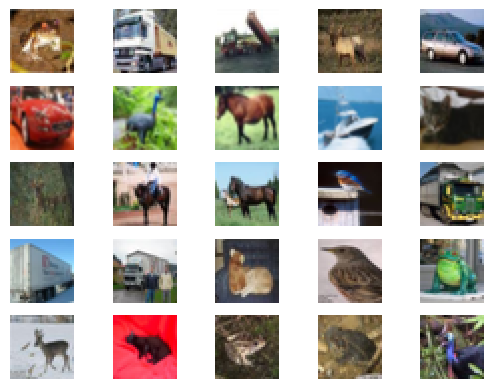

In [5]:
(trainX, trainy), (testX, testy) = load_data()

# plot 25 images
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(trainX[i])
plt.show()

In [20]:
# load the cifar images and build a training data set
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    # convert to float and scale.
    X = trainX.astype('float32')
    # the generator uses tanh as activation function (see above), 
    # so we need to rescale from [0,255] to [-1,1]
    # original images to -1 to 1 to match the output of generator.
    X = (X - 127.5) / 127.5  
    
    return X

In [21]:
# Pick a batch of random real samples to train the GAN
# In fact, we will train the GAN on a half batch of real images and another 
# half batch of fake images. 
# For each real image we assign a label 1 and for fake we assign label 0. 

def generate_real_samples(dataset, n_samples):
    # choose random images
    ix = randint(0, dataset.shape[0], n_samples)
    # select the random images and assign it to X
    x = dataset[ix]
    # generate class labels and assign to y
    y = ones((n_samples, 1)) # label=1 indicates that the image is a real one
    return x, y

In [22]:
# generate n_samples number of latent vectors as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [23]:
# use the generator to generate n fake examples, with class labels
# Supply the generator, latent_dim and number of samples as input.
# Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict using generator to generate fake samples. 
    x = generator.predict(x_input)
    # Class labels will be 0 as these samples are fake. 
    y = zeros((n_samples, 1))  # label=0 indicates that the image is a fake one
    return x, y

### Train the generator and discriminator
We loop through a number of epochs to train the discriminator by first selecting a random batch of images from our true/real data set. Then, generating a set of images using the generator. Feed both sets of images into the discriminator. Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
    # manually enumerate epochs and bacthes. 
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # Train the discriminator on real and fake images, separately (half batch each)
            #Research showed that separate training is more effective. 
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
            d_loss_real, _ = d_model.train_on_batch(X_real, y_real) 
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
             
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)			
            y_gan = ones((n_batch, 1))
            
            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # Print losses on this batch
            print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                 (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    # save the generator model
    g_model.save('cifar_generator_2epochs.h5')

In [25]:
### Train the GAN

In [26]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=2)

Epoch>1, Batch 1/390, d1=0.638, d2=0.697 g=0.690
Epoch>1, Batch 2/390, d1=0.580, d2=0.704 g=0.682
Epoch>1, Batch 3/390, d1=0.506, d2=0.718 g=0.671
Epoch>1, Batch 4/390, d1=0.460, d2=0.739 g=0.653
Epoch>1, Batch 5/390, d1=0.406, d2=0.768 g=0.635
Epoch>1, Batch 6/390, d1=0.366, d2=0.799 g=0.620
Epoch>1, Batch 7/390, d1=0.310, d2=0.816 g=0.617
Epoch>1, Batch 8/390, d1=0.288, d2=0.814 g=0.640
Epoch>1, Batch 9/390, d1=0.245, d2=0.780 g=0.696
Epoch>1, Batch 10/390, d1=0.230, d2=0.732 g=0.754
Epoch>1, Batch 11/390, d1=0.213, d2=0.721 g=0.787
Epoch>1, Batch 12/390, d1=0.202, d2=0.720 g=0.809
Epoch>1, Batch 13/390, d1=0.199, d2=0.743 g=0.783
Epoch>1, Batch 14/390, d1=0.230, d2=0.793 g=0.742
Epoch>1, Batch 15/390, d1=0.235, d2=0.833 g=0.708
Epoch>1, Batch 16/390, d1=0.272, d2=0.869 g=0.682
Epoch>1, Batch 17/390, d1=0.306, d2=0.904 g=0.662
Epoch>1, Batch 18/390, d1=0.297, d2=0.898 g=0.675
Epoch>1, Batch 19/390, d1=0.321, d2=0.908 g=0.680
Epoch>1, Batch 20/390, d1=0.316, d2=0.986 g=0.660
Epoch>1, 

Epoch>1, Batch 164/390, d1=0.422, d2=0.362 g=1.316
Epoch>1, Batch 165/390, d1=0.371, d2=0.359 g=1.307
Epoch>1, Batch 166/390, d1=0.338, d2=0.358 g=1.330
Epoch>1, Batch 167/390, d1=0.396, d2=0.365 g=1.248
Epoch>1, Batch 168/390, d1=0.251, d2=0.373 g=1.226
Epoch>1, Batch 169/390, d1=0.306, d2=0.400 g=1.178
Epoch>1, Batch 170/390, d1=0.297, d2=0.457 g=1.086
Epoch>1, Batch 171/390, d1=0.298, d2=0.548 g=0.934
Epoch>1, Batch 172/390, d1=0.208, d2=0.786 g=0.761
Epoch>1, Batch 173/390, d1=0.178, d2=1.332 g=0.642
Epoch>1, Batch 174/390, d1=0.191, d2=1.500 g=0.754
Epoch>1, Batch 175/390, d1=0.175, d2=1.235 g=1.248
Epoch>1, Batch 176/390, d1=0.259, d2=0.605 g=2.129
Epoch>1, Batch 177/390, d1=0.345, d2=0.156 g=2.721
Epoch>1, Batch 178/390, d1=0.344, d2=0.140 g=2.788
Epoch>1, Batch 179/390, d1=0.342, d2=0.145 g=2.659
Epoch>1, Batch 180/390, d1=0.428, d2=0.195 g=2.302
Epoch>1, Batch 181/390, d1=0.423, d2=0.289 g=2.416
Epoch>1, Batch 182/390, d1=0.465, d2=0.265 g=2.372
Epoch>1, Batch 183/390, d1=0.43

Epoch>1, Batch 325/390, d1=0.613, d2=0.474 g=1.304
Epoch>1, Batch 326/390, d1=0.654, d2=0.423 g=1.513
Epoch>1, Batch 327/390, d1=0.620, d2=0.350 g=1.582
Epoch>1, Batch 328/390, d1=0.633, d2=0.310 g=1.766
Epoch>1, Batch 329/390, d1=0.565, d2=0.257 g=1.972
Epoch>1, Batch 330/390, d1=0.594, d2=0.215 g=2.089
Epoch>1, Batch 331/390, d1=0.634, d2=0.208 g=2.109
Epoch>1, Batch 332/390, d1=0.477, d2=0.223 g=2.224
Epoch>1, Batch 333/390, d1=0.422, d2=0.187 g=2.109
Epoch>1, Batch 334/390, d1=0.513, d2=0.256 g=2.097
Epoch>1, Batch 335/390, d1=0.533, d2=0.333 g=2.053
Epoch>1, Batch 336/390, d1=0.465, d2=0.307 g=2.340
Epoch>1, Batch 337/390, d1=0.517, d2=0.328 g=2.643
Epoch>1, Batch 338/390, d1=0.585, d2=0.292 g=2.567
Epoch>1, Batch 339/390, d1=0.559, d2=0.527 g=2.380
Epoch>1, Batch 340/390, d1=0.664, d2=0.448 g=2.214
Epoch>1, Batch 341/390, d1=0.668, d2=0.524 g=1.929
Epoch>1, Batch 342/390, d1=0.782, d2=0.572 g=2.115
Epoch>1, Batch 343/390, d1=0.961, d2=0.734 g=1.540
Epoch>1, Batch 344/390, d1=0.89

Epoch>2, Batch 98/390, d1=0.726, d2=0.697 g=0.781
Epoch>2, Batch 99/390, d1=0.717, d2=0.687 g=0.781
Epoch>2, Batch 100/390, d1=0.712, d2=0.659 g=0.840
Epoch>2, Batch 101/390, d1=0.734, d2=0.655 g=0.816
Epoch>2, Batch 102/390, d1=0.755, d2=0.663 g=0.833
Epoch>2, Batch 103/390, d1=0.736, d2=0.648 g=0.812
Epoch>2, Batch 104/390, d1=0.737, d2=0.667 g=0.813
Epoch>2, Batch 105/390, d1=0.685, d2=0.683 g=0.808
Epoch>2, Batch 106/390, d1=0.699, d2=0.686 g=0.758
Epoch>2, Batch 107/390, d1=0.742, d2=0.696 g=0.743
Epoch>2, Batch 108/390, d1=0.736, d2=0.650 g=0.788
Epoch>2, Batch 109/390, d1=0.759, d2=0.671 g=0.794
Epoch>2, Batch 110/390, d1=0.754, d2=0.615 g=0.783
Epoch>2, Batch 111/390, d1=0.727, d2=0.663 g=0.812
Epoch>2, Batch 112/390, d1=0.760, d2=0.673 g=0.808
Epoch>2, Batch 113/390, d1=0.736, d2=0.656 g=0.815
Epoch>2, Batch 114/390, d1=0.707, d2=0.663 g=0.819
Epoch>2, Batch 115/390, d1=0.695, d2=0.616 g=0.918
Epoch>2, Batch 116/390, d1=0.711, d2=0.606 g=0.878
Epoch>2, Batch 117/390, d1=0.739,

Epoch>2, Batch 259/390, d1=0.659, d2=0.600 g=0.871
Epoch>2, Batch 260/390, d1=0.686, d2=0.571 g=0.892
Epoch>2, Batch 261/390, d1=0.673, d2=0.598 g=0.888
Epoch>2, Batch 262/390, d1=0.606, d2=0.582 g=0.924
Epoch>2, Batch 263/390, d1=0.644, d2=0.628 g=0.893
Epoch>2, Batch 264/390, d1=0.568, d2=0.707 g=0.809
Epoch>2, Batch 265/390, d1=0.610, d2=0.662 g=0.797
Epoch>2, Batch 266/390, d1=0.586, d2=0.694 g=0.785
Epoch>2, Batch 267/390, d1=0.584, d2=0.721 g=0.789
Epoch>2, Batch 268/390, d1=0.606, d2=0.691 g=0.763
Epoch>2, Batch 269/390, d1=0.601, d2=0.684 g=0.740
Epoch>2, Batch 270/390, d1=0.623, d2=0.708 g=0.797
Epoch>2, Batch 271/390, d1=0.615, d2=0.690 g=0.819
Epoch>2, Batch 272/390, d1=0.680, d2=0.694 g=0.839
Epoch>2, Batch 273/390, d1=0.675, d2=0.640 g=0.898
Epoch>2, Batch 274/390, d1=0.653, d2=0.649 g=0.895
Epoch>2, Batch 275/390, d1=0.688, d2=0.631 g=0.878
Epoch>2, Batch 276/390, d1=0.686, d2=0.638 g=0.856
Epoch>2, Batch 277/390, d1=0.694, d2=0.619 g=0.861
Epoch>2, Batch 278/390, d1=0.65

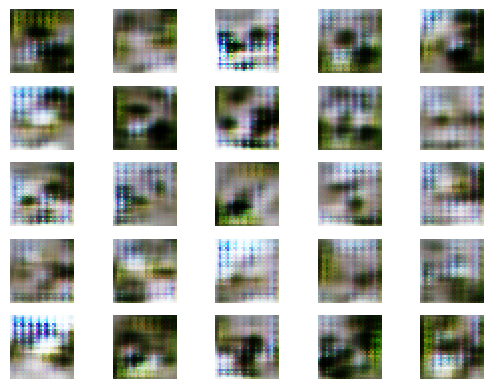

In [28]:
# Now, let us load the generator model and generate images

from keras.models import load_model
from numpy.random import randn


# Plot generated images 
def show_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, :])
    plt.show()

# load model
#model = load_model('cifar_generator_2epochs.h5') #Model trained for 100 epochs
model = g_model
# generate images
latent_points = generate_latent_points(100, 25)  #Latent dim and n_samples
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

import numpy as np
X = (X*255).astype(np.uint8)

# plot the result
show_plot(X, 5)

#Note: CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse,
# ship, truck